In [310]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt

In [311]:

#hyperparameters
BATCH_SIZE = 32
GAMMA = 0.95
LR = 0.02
env = gym.make('CartPole-v0')
env = env.unwrapped
REWARD_DELAY = 0.95
N_ACTIONS = env.action_space.n
N_FEATURES = env.observation_space.shape[0]



In [327]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_FEATURES, 10)
        self.fc1.weight.data.normal_(0, 0.1)
        self.out = nn.Linear(10, N_ACTIONS)
        #self.softmax = stable_softmax()
        self.out.weight.data.normal_(0, 0.1)
    def forward(self, x):
       
        x = self.fc1(x)
        x = F.relu(x)
        x = self.out(x)
        max_val = x.max()
        x = x - max_val
        print(x)
        prob_actions = F.softmax(x, dim=1)
        print(prob_actions)
        return prob_actions

In [328]:
class PolicyGradient(object):
    def __init__(self):
        self.ep_obs, self.ep_as, self.ep_rs = [], [], []
        self.policy_net = Net()
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=LR)
        self.loss_func = nn.CrossEntropyLoss()
        self.gamma = GAMMA
        
    def choose_action(self, x):
        x = Variable(torch.unsqueeze(torch.FloatTensor(x),0))
        prob_weights = self.policy_net.forward(x)
       # print(x)
       # print(prob_weights)
        action = np.random.choice(range(prob_weights.shape[1]), p=prob_weights.view(-1).detach().numpy())
        return action
    def store_transition(self, s, a, r):
        self.ep_obs.append(s)
        self.ep_as.append(a)
        self.ep_rs.append(r)
    def _discount_and_norm_rewards(self):
        discounted_ep_rs = np.zeros_like(self.ep_rs)
        running_add = 0
        for t in reversed(range(0, len(self.ep_rs))):
            running_add = running_add * self.gamma + self.ep_rs[t]
            discounted_ep_rs[t] = running_add
            
        #normalize
        discounted_ep_rs -= np.mean(discounted_ep_rs)
        discounted_ep_rs /= np.std(discounted_ep_rs)
        return discounted_ep_rs
    def learn(self):
        discounted_ep_rs_norm = self._discount_and_norm_rewards()
        discounted_ep_rs_norm_ = Variable(torch.unsqueeze(torch.FloatTensor(discounted_ep_rs_norm),0))
        input_ = Variable(torch.unsqueeze(torch.FloatTensor(self.ep_obs),0))
        
        prob_all_actions = self.policy_net.forward(input_)
        #one hot labels
       
        as_ = Variable(torch.unsqueeze(torch.FloatTensor(self.ep_as), -1)).float()
     
        one_hot_target = (as_ == torch.arange(N_ACTIONS).reshape(1, N_ACTIONS).float()).float()
        
        neg_log_prob = torch.sum((-torch.log(prob_all_actions)*one_hot_target).squeeze(0), dim=1)
        
      
        loss = torch.sum((neg_log_prob * discounted_ep_rs_norm_)).mean()
        print(loss)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.ep_obs, self.ep_as, self.ep_rs = [], [], []    # empty episode data
        return discounted_ep_rs_norm
        
        

In [329]:
PG = PolicyGradient()

tensor([[-0.2006,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4500, 0.5500]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1829,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4544, 0.5456]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2012,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4499, 0.5501]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2086,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4480, 0.5520]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2108,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4475, 0.5525]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2084,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4481, 0.5519]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2007,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4500, 0.5500]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1832,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4543, 0.5457]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2015,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4498, 0.5502]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1839,  0.0000]], grad_fn=

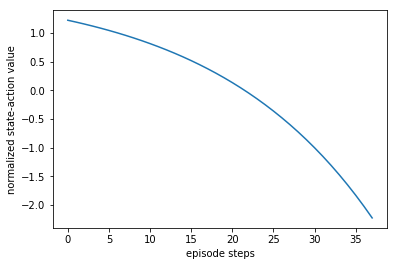

tensor([[-0.2149,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4465, 0.5535]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1929,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4519, 0.5481]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2163,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4461, 0.5539]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1942,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4516, 0.5484]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2175,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4458, 0.5542]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1954,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4513, 0.5487]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1736,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4567, 0.5433]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1521,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4620, 0.5380]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1759,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4561, 0.5439]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1541,  0.0000]], grad_fn=

tensor([[-0.3343,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4172, 0.5828]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3422,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4153, 0.5847]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3504,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4133, 0.5867]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3589,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4112, 0.5888]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3675,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4092, 0.5908]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3614,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4106, 0.5894]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3701,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4085, 0.5915]], grad_fn=<SoftmaxBackward>)
episode: 4   reward: 23
tensor([[[-0.3590, -0.0939],
         [-0.3518, -0.1320],
         [-0.3588, -0.0953],
         [-0.3607, -0.0677],
         [-0.3621, -0.0553],
         [-0.3656, -0.0445],
         [-0.3685, -0.0342],
         [-0.3690, -0.02

tensor([[-0.0115,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4971, 0.5029]], grad_fn=<SoftmaxBackward>)
episode: 8   reward: 22
tensor([[[-0.2748,  0.0000],
         [-0.2728, -0.0724],
         [-0.2712, -0.1455],
         [-0.2698, -0.2195],
         [-0.2687, -0.2947],
         [-0.2712, -0.2303],
         [-0.2700, -0.3071],
         [-0.2724, -0.2447],
         [-0.2745, -0.1829],
         [-0.2728, -0.2614]]], grad_fn=<SubBackward0>)
tensor([[[0.0997, 0.1211],
         [0.0999, 0.1126],
         [0.1001, 0.1047],
         [0.1002, 0.0972],
         [0.1003, 0.0902],
         [0.1001, 0.0962],
         [0.1002, 0.0891],
         [0.0999, 0.0948],
         [0.0997, 0.1009],
         [0.0999, 0.0932]]], grad_fn=<SoftmaxBackward>)
tensor(-0.4397, grad_fn=<MeanBackward0>)
tensor([[-0.2813,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4301, 0.5699]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3430,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4151, 0.5849]], grad_fn=<SoftmaxBackward>)

tensor([[-0.0996,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4751, 0.5249]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1994,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4503, 0.5497]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2995,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4257, 0.5743]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2022,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4496, 0.5504]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3021,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4250, 0.5750]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3756,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4072, 0.5928]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3062,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4241, 0.5759]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3777,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4067, 0.5933]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3113,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4228, 0.5772]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2151,  0.0000]], grad_fn=

tensor([[-0.2840,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4295, 0.5705]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1739,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4566, 0.5434]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2831,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4297, 0.5703]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1724,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4570, 0.5430]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0606,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4849, 0.5151]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1677,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4582, 0.5418]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0546,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4864, 0.5136]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0601]], grad_fn=<SubBackward0>)
tensor([[0.5150, 0.4850]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0436,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4891, 0.5109]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0732]], grad_fn=

tensor([[-0.0152,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4962, 0.5038]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1435,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4642, 0.5358]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0049,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4988, 0.5012]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1315,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4672, 0.5328]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2584,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4358, 0.5642]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1190,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4703, 0.5297]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0220]], grad_fn=<SubBackward0>)
tensor([[0.5055, 0.4945]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1018,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4746, 0.5254]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2255,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4439, 0.5561]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3486,  0.0000]], grad_fn=

tensor([[ 0.0000, -0.0926]], grad_fn=<SubBackward0>)
tensor([[0.5231, 0.4769]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0372,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4907, 0.5093]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1217]], grad_fn=<SubBackward0>)
tensor([[0.5304, 0.4696]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0051,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4987, 0.5013]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1315,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4672, 0.5328]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0291]], grad_fn=<SubBackward0>)
tensor([[0.5073, 0.4927]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1920]], grad_fn=<SubBackward0>)
tensor([[0.5479, 0.4521]], grad_fn=<SoftmaxBackward>)
episode: 15   reward: 23
tensor([[[-0.4572, -0.1765],
         [-0.4532, -0.0585],
         [-0.4562, -0.1720],
         [-0.4533, -0.0566],
         [-0.4550, -0.1663],
         [-0.4840, -0.3384],
         [-0.4551, -0.1639],
         [-0.4841, -0.3

tensor([[ 0.0000, -0.2992]], grad_fn=<SubBackward0>)
tensor([[0.5742, 0.4258]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1421]], grad_fn=<SubBackward0>)
tensor([[0.5355, 0.4645]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3284]], grad_fn=<SubBackward0>)
tensor([[0.5814, 0.4186]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1820]], grad_fn=<SubBackward0>)
tensor([[0.5454, 0.4546]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0219]], grad_fn=<SubBackward0>)
tensor([[0.5055, 0.4945]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2259]], grad_fn=<SubBackward0>)
tensor([[0.5562, 0.4438]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0697]], grad_fn=<SubBackward0>)
tensor([[0.5174, 0.4826]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2727]], grad_fn=<SubBackward0>)
tensor([[0.5678, 0.4322]], grad_fn=<SoftmaxBackward>)
episode: 18   reward: 23
tensor([[[-0.3042,  0.0000],
         [-0.3680, -0.2517],
         [-0.3077, -0.0143],
         [-0.3717, -0.2669],
   

tensor([[0.5894, 0.4106]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1667]], grad_fn=<SubBackward0>)
tensor([[0.5416, 0.4584]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3664]], grad_fn=<SubBackward0>)
tensor([[0.5906, 0.4094]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5364]], grad_fn=<SubBackward0>)
tensor([[0.6310, 0.3690]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3809]], grad_fn=<SubBackward0>)
tensor([[0.5941, 0.4059]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1987]], grad_fn=<SubBackward0>)
tensor([[0.5495, 0.4505]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0005,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4999, 0.5001]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2010,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4499, 0.5501]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4038,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4004, 0.5996]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1901,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4526, 0.5474]], grad_fn=<S

tensor([[0.6494, 0.3506]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8113]], grad_fn=<SubBackward0>)
tensor([[0.6924, 0.3076]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6502]], grad_fn=<SubBackward0>)
tensor([[0.6571, 0.3429]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4913]], grad_fn=<SubBackward0>)
tensor([[0.6204, 0.3796]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3237]], grad_fn=<SubBackward0>)
tensor([[0.5802, 0.4198]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1194]], grad_fn=<SubBackward0>)
tensor([[0.5298, 0.4702]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0853,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4787, 0.5213]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1782]], grad_fn=<SubBackward0>)
tensor([[0.5444, 0.4556]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0232,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4942, 0.5058]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2253,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4439, 0.5561]], grad_fn=<S

tensor([[0.4311, 0.5689]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5443,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3672, 0.6328]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6682,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3389, 0.6611]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5596,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3636, 0.6364]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3147,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4220, 0.5780]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0550,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4863, 0.5137]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2087]], grad_fn=<SubBackward0>)
tensor([[0.5520, 0.4480]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0592,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4852, 0.5148]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2071]], grad_fn=<SubBackward0>)
tensor([[0.5516, 0.4484]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4707]], grad_fn=<SubBackward0>)
tensor([[0.6156, 0.3844]], grad_fn=<S

tensor([[0.5313, 0.4687]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4411]], grad_fn=<SubBackward0>)
tensor([[0.6085, 0.3915]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1844]], grad_fn=<SubBackward0>)
tensor([[0.5460, 0.4540]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0734,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4817, 0.5183]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3334,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4174, 0.5826]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0195,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4951, 0.5049]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2992]], grad_fn=<SubBackward0>)
tensor([[0.5742, 0.4258]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0469]], grad_fn=<SubBackward0>)
tensor([[0.5117, 0.4883]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3693]], grad_fn=<SubBackward0>)
tensor([[0.5913, 0.4087]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1224]], grad_fn=<SubBackward0>)
tensor([[0.5306, 0.4694]], grad_fn=<S

tensor([[ 0.0000, -0.4677]], grad_fn=<SubBackward0>)
tensor([[0.6148, 0.3852]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7813]], grad_fn=<SubBackward0>)
tensor([[0.6860, 0.3140]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.0604]], grad_fn=<SubBackward0>)
tensor([[0.7428, 0.2572]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8482]], grad_fn=<SubBackward0>)
tensor([[0.7002, 0.2998]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6295]], grad_fn=<SubBackward0>)
tensor([[0.6524, 0.3476]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.9199]], grad_fn=<SubBackward0>)
tensor([[0.7150, 0.2850]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7181]], grad_fn=<SubBackward0>)
tensor([[0.6722, 0.3278]], grad_fn=<SoftmaxBackward>)
episode: 30   reward: 23
tensor([[[-0.2834,  0.0000],
         [-0.6033, -0.6514],
         [-0.9291, -1.3144],
         [-0.6414, -0.7284],
         [-0.3509, -0.1373],
         [-0.6765, -0.8006],
         [-1.0084, -1.4761],
         [-1.3394, -2.1

tensor([[0.5788, 0.4212]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0141,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4965, 0.5035]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3490,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4136, 0.5864]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0053]], grad_fn=<SubBackward0>)
tensor([[0.5013, 0.4987]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3276,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4188, 0.5812]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6640,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3398, 0.6602]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3143,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4221, 0.5779]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0415]], grad_fn=<SubBackward0>)
tensor([[0.5104, 0.4896]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4040]], grad_fn=<SubBackward0>)
tensor([[0.5996, 0.4004]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7628]], grad_fn=<SubBackward0>)
tensor([[0.6820, 0.3180]], grad_fn=<S

tensor([[0.3211, 0.6789]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3863,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4046, 0.5954]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0148,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4963, 0.5037]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3633]], grad_fn=<SubBackward0>)
tensor([[0.5898, 0.4102]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7498]], grad_fn=<SubBackward0>)
tensor([[0.6791, 0.3209]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4061]], grad_fn=<SubBackward0>)
tensor([[0.6002, 0.3998]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8000]], grad_fn=<SubBackward0>)
tensor([[0.6900, 0.3100]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.1335]], grad_fn=<SubBackward0>)
tensor([[0.7565, 0.2435]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8670]], grad_fn=<SubBackward0>)
tensor([[0.7041, 0.2959]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5568]], grad_fn=<SubBackward0>)
tensor([[0.6357, 0.3643]], grad_fn=<S

tensor([[-0.8876,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2916, 0.7084]], grad_fn=<SoftmaxBackward>)
tensor([[-0.9954,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2698, 0.7302]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1074,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2484, 0.7516]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0265,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2638, 0.7362]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1417,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2420, 0.7580]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0647,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2564, 0.7436]], grad_fn=<SoftmaxBackward>)
tensor([[-0.9869,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2715, 0.7285]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1037,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2490, 0.7510]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0297,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2631, 0.7369]], grad_fn=<SoftmaxBackward>)
episode: 36   reward: 23
tensor([[[-1

tensor([[-0.5514,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3655, 0.6345]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8635,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2966, 0.7034]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5558,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3645, 0.6355]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8671,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2959, 0.7041]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5645,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3625, 0.6375]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1663,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4585, 0.5415]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2398]], grad_fn=<SubBackward0>)
tensor([[0.5597, 0.4403]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6554]], grad_fn=<SubBackward0>)
tensor([[0.6582, 0.3418]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2811]], grad_fn=<SubBackward0>)
tensor([[0.5698, 0.4302]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7050]], grad_fn=

tensor([[0.7160, 0.2840]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.3714]], grad_fn=<SubBackward0>)
tensor([[0.7976, 0.2024]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.0450]], grad_fn=<SubBackward0>)
tensor([[0.7398, 0.2602]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6900]], grad_fn=<SubBackward0>)
tensor([[0.6660, 0.3340]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.1746]], grad_fn=<SubBackward0>)
tensor([[0.7640, 0.2360]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8385]], grad_fn=<SubBackward0>)
tensor([[0.6982, 0.3018]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.3095]], grad_fn=<SubBackward0>)
tensor([[0.7874, 0.2126]], grad_fn=<SoftmaxBackward>)
episode: 40   reward: 23
tensor([[[-1.5245, -1.0061],
         [-1.0615, -0.1747],
         [-0.9867,  0.0000],
         [-1.0511, -0.1536],
         [-1.4966, -0.9598],
         [-2.0858, -1.9737],
         [-1.5080, -0.9792],
         [-2.1003, -1.9986],
         [-1.5257, -1.0097],
         [-2.1213,

tensor([[0.3797, 0.6203]], grad_fn=<SoftmaxBackward>)
tensor([[-0.9511,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2787, 0.7213]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0737,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2547, 0.7453]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1905,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2332, 0.7668]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0994,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2499, 0.7501]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0055,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2679, 0.7321]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1216,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2457, 0.7543]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0297,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2631, 0.7369]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7360,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3239, 0.6761]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0491,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2594, 0.7406]], grad_fn=<S

tensor([[ 0.0000, -0.3276]], grad_fn=<SubBackward0>)
tensor([[0.5812, 0.4188]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1666,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4584, 0.5416]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3280]], grad_fn=<SubBackward0>)
tensor([[0.5813, 0.4187]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1614,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4597, 0.5403]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3383]], grad_fn=<SubBackward0>)
tensor([[0.5838, 0.4162]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1464,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4635, 0.5365]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6387,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3455, 0.6545]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1438,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4641, 0.5359]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3613]], grad_fn=<SubBackward0>)
tensor([[0.5894, 0.4106]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1180,  0.0000]], grad_fn=

tensor([[-0.0848,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4788, 0.5212]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4726]], grad_fn=<SubBackward0>)
tensor([[0.6160, 0.3840]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0220]], grad_fn=<SubBackward0>)
tensor([[0.5055, 0.4945]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5862]], grad_fn=<SubBackward0>)
tensor([[0.6425, 0.3575]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1443]], grad_fn=<SubBackward0>)
tensor([[0.5360, 0.4640]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7163]], grad_fn=<SubBackward0>)
tensor([[0.6718, 0.3282]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2850]], grad_fn=<SubBackward0>)
tensor([[0.5708, 0.4292]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1505,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4624, 0.5376]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5921,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3562, 0.6438]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0274,  0.0000]], grad_fn=

tensor([[ 0.0000, -0.5400]], grad_fn=<SubBackward0>)
tensor([[0.6318, 0.3682]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0456]], grad_fn=<SubBackward0>)
tensor([[0.5114, 0.4886]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6275]], grad_fn=<SubBackward0>)
tensor([[0.6519, 0.3481]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1422]], grad_fn=<SubBackward0>)
tensor([[0.5355, 0.4645]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7325]], grad_fn=<SubBackward0>)
tensor([[0.6754, 0.3246]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2575]], grad_fn=<SubBackward0>)
tensor([[0.5640, 0.4360]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8571]], grad_fn=<SubBackward0>)
tensor([[0.7021, 0.2979]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3939]], grad_fn=<SubBackward0>)
tensor([[0.5972, 0.4028]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0737,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4816, 0.5184]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5284]], grad_fn=

tensor([[-0.0340,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4915, 0.5085]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5745]], grad_fn=<SubBackward0>)
tensor([[0.6398, 0.3602]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0481]], grad_fn=<SubBackward0>)
tensor([[0.5120, 0.4880]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6652]], grad_fn=<SubBackward0>)
tensor([[0.6604, 0.3396]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1487]], grad_fn=<SubBackward0>)
tensor([[0.5371, 0.4629]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3743,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4075, 0.5925]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2425]], grad_fn=<SubBackward0>)
tensor([[0.5603, 0.4397]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2742,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4319, 0.5681]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3486]], grad_fn=<SubBackward0>)
tensor([[0.5863, 0.4137]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1604,  0.0000]], grad_fn=

tensor([[-0.0151,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4962, 0.5038]], grad_fn=<SoftmaxBackward>)
episode: 50   reward: 24
tensor([[[-2.4357, -1.8410],
         [-1.4931, -0.3600],
         [-1.3361, -0.0673],
         [-1.4701, -0.3191],
         [-2.3123, -1.6486],
         [-3.3538, -3.2709],
         [-2.2960, -1.6226],
         [-1.4586, -0.2978],
         [-1.2988,  0.0000],
         [-1.4299, -0.2463],
         [-2.1040, -1.3225],
         [-3.1256, -2.9134],
         [-2.0479, -1.2339],
         [-3.0706, -2.8266],
         [-4.1162, -4.4549],
         [-5.1893, -6.1261],
         [-4.1711, -4.5393],
         [-5.2633, -6.2405],
         [-4.2633, -4.6823],
         [-5.3744, -6.4132],
         [-4.3935, -4.8851],
         [-5.5237, -6.6461],
         [-4.5635, -5.1505],
         [-3.5919, -3.6374],
         [-2.6046, -2.0999],
         [-3.7170, -3.8337],
         [-4.8546, -5.6066],
         [-6.0219, -7.4259],
         [-5.1054, -5.9989],
         [-6.2963, -7.8552]

tensor([[0.2364, 0.7636]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6036,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3535, 0.6465]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0151]], grad_fn=<SubBackward0>)
tensor([[0.5038, 0.4962]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5813,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3586, 0.6414]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1619,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2383, 0.7617]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5801,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3589, 0.6411]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0410]], grad_fn=<SubBackward0>)
tensor([[0.5103, 0.4897]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5526,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3653, 0.6347]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1429,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2418, 0.7582]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5457,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3669, 0.6331]], grad_fn=<S

tensor([[ 0.0000, -0.3734]], grad_fn=<SubBackward0>)
tensor([[0.5923, 0.4077]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.0630]], grad_fn=<SubBackward0>)
tensor([[0.7433, 0.2567]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5288]], grad_fn=<SubBackward0>)
tensor([[0.6292, 0.3708]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0113,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4972, 0.5028]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6805]], grad_fn=<SubBackward0>)
tensor([[0.6638, 0.3362]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1505]], grad_fn=<SubBackward0>)
tensor([[0.5376, 0.4624]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8513]], grad_fn=<SubBackward0>)
tensor([[0.7008, 0.2992]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3336]], grad_fn=<SubBackward0>)
tensor([[0.5826, 0.4174]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1901,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4526, 0.5474]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7223,  0.0000]], grad_fn=

tensor([[0.3469, 0.6531]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2102,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2297, 0.7703]], grad_fn=<SoftmaxBackward>)
tensor([[-1.3620,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2039, 0.7961]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2309,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2260, 0.7740]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7144,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3286, 0.6714]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2435,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2238, 0.7762]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7586,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3189, 0.6811]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2581,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2213, 0.7787]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8108,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3077, 0.6923]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2751,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2184, 0.7816]], grad_fn=<S

tensor([[0.6389, 0.3611]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0533,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4867, 0.5133]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6881,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3345, 0.6655]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0666,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4833, 0.5167]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7003,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3318, 0.6682]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2457,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2235, 0.7765]], grad_fn=<SoftmaxBackward>)
tensor([[-1.4026,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.1974, 0.8026]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2733,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2187, 0.7813]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8321,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3032, 0.6968]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2941,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2152, 0.7848]], grad_fn=<S

tensor([[-0.1554,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4612, 0.5388]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7730,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3158, 0.6842]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1454,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4637, 0.5363]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4976]], grad_fn=<SubBackward0>)
tensor([[0.6219, 0.3781]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.1589]], grad_fn=<SubBackward0>)
tensor([[0.7611, 0.2389]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5826]], grad_fn=<SubBackward0>)
tensor([[0.6417, 0.3583]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0008,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4998, 0.5002]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6638]], grad_fn=<SubBackward0>)
tensor([[0.6601, 0.3399]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0895]], grad_fn=<SubBackward0>)
tensor([[0.5224, 0.4776]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4942,  0.0000]], grad_fn=

tensor([[-0.4576,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3876, 0.6124]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1871]], grad_fn=<SubBackward0>)
tensor([[0.5466, 0.4534]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8491]], grad_fn=<SubBackward0>)
tensor([[0.7004, 0.2996]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.5314]], grad_fn=<SubBackward0>)
tensor([[0.8222, 0.1778]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.9947]], grad_fn=<SubBackward0>)
tensor([[0.7300, 0.2700]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4536]], grad_fn=<SubBackward0>)
tensor([[0.6115, 0.3885]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0944,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4764, 0.5236]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6521,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3425, 0.6575]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0154]], grad_fn=<SubBackward0>)
tensor([[0.5038, 0.4962]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6996]], grad_fn=

tensor([[ 0.0000, -0.7085]], grad_fn=<SubBackward0>)
tensor([[0.6701, 0.3299]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1362]], grad_fn=<SubBackward0>)
tensor([[0.5340, 0.4660]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4465,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3902, 0.6098]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1868]], grad_fn=<SubBackward0>)
tensor([[0.5466, 0.4534]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3923,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4032, 0.5968]], grad_fn=<SoftmaxBackward>)
tensor([[-0.9845,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2720, 0.7280]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3636,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4101, 0.5899]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2717]], grad_fn=<SubBackward0>)
tensor([[0.5675, 0.4325]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3049,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4244, 0.5756]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8941,  0.0000]], grad_fn=

tensor([[ 0.0000, -0.6218]], grad_fn=<SubBackward0>)
tensor([[0.6506, 0.3494]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0918]], grad_fn=<SubBackward0>)
tensor([[0.5229, 0.4771]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4460,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3903, 0.6097]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2265]], grad_fn=<SubBackward0>)
tensor([[0.5564, 0.4436]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.9181]], grad_fn=<SubBackward0>)
tensor([[0.7146, 0.2854]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.6317]], grad_fn=<SubBackward0>)
tensor([[0.8364, 0.1636]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.1531]], grad_fn=<SubBackward0>)
tensor([[0.7601, 0.2399]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6736]], grad_fn=<SubBackward0>)
tensor([[0.6623, 0.3377]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1906]], grad_fn=<SubBackward0>)
tensor([[0.5475, 0.4525]], grad_fn=<SoftmaxBackward>)
episode: 60   reward: 26
tensor([[[ -

tensor([[0.4921, 0.5079]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5968]], grad_fn=<SubBackward0>)
tensor([[0.6449, 0.3551]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0123]], grad_fn=<SubBackward0>)
tensor([[0.5031, 0.4969]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6494]], grad_fn=<SubBackward0>)
tensor([[0.6569, 0.3431]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0737]], grad_fn=<SubBackward0>)
tensor([[0.5184, 0.4816]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7196]], grad_fn=<SubBackward0>)
tensor([[0.6725, 0.3275]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1533]], grad_fn=<SubBackward0>)
tensor([[0.5383, 0.4617]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8085]], grad_fn=<SubBackward0>)
tensor([[0.6918, 0.3082]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2527]], grad_fn=<SubBackward0>)
tensor([[0.5628, 0.4372]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.9178]], grad_fn=<SubBackward0>)
tensor([[0.7146, 0.2854]], grad_fn=<S

tensor([[0.6738, 0.3262]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2027]], grad_fn=<SubBackward0>)
tensor([[0.5505, 0.4495]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8968]], grad_fn=<SubBackward0>)
tensor([[0.7103, 0.2897]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.6126]], grad_fn=<SubBackward0>)
tensor([[0.8338, 0.1662]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.1302]], grad_fn=<SubBackward0>)
tensor([[0.7559, 0.2441]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.8636]], grad_fn=<SubBackward0>)
tensor([[0.8657, 0.1343]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.4071]], grad_fn=<SubBackward0>)
tensor([[0.8033, 0.1967]], grad_fn=<SoftmaxBackward>)
episode: 62   reward: 27
tensor([[[-3.3566e+00, -2.7902e+00],
         [-5.1951e+00, -5.2424e+00],
         [-7.0848e+00, -7.7628e+00],
         [-5.3314e+00, -5.4238e+00],
         [-3.5439e+00, -3.0395e+00],
         [-5.4167e+00, -5.5377e+00],
         [-7.3415e+00, -8.1051e+00],
         [-5.6244e+0

tensor([[-0.3681,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4090, 0.5910]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2740]], grad_fn=<SubBackward0>)
tensor([[0.5681, 0.4319]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2970,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4263, 0.5737]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3507]], grad_fn=<SubBackward0>)
tensor([[0.5868, 0.4132]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2136,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4468, 0.5532]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7903,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3121, 0.6879]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2452,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2235, 0.7765]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7625,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3181, 0.6819]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1285,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4679, 0.5321]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5228]], grad_fn=

tensor([[0.3934, 0.6066]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1844]], grad_fn=<SubBackward0>)
tensor([[0.5460, 0.4540]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8200]], grad_fn=<SubBackward0>)
tensor([[0.6942, 0.3058]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.4773]], grad_fn=<SubBackward0>)
tensor([[0.8142, 0.1858]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.9404]], grad_fn=<SubBackward0>)
tensor([[0.7192, 0.2808]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3968]], grad_fn=<SubBackward0>)
tensor([[0.5979, 0.4021]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.0607]], grad_fn=<SubBackward0>)
tensor([[0.7428, 0.2572]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5302]], grad_fn=<SubBackward0>)
tensor([[0.6295, 0.3705]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0093,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4977, 0.5023]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6541]], grad_fn=<SubBackward0>)
tensor([[0.6579, 0.3421]], grad_fn=<S

tensor([[-0.5164,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3737, 0.6263]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0839]], grad_fn=<SubBackward0>)
tensor([[0.5210, 0.4790]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4760,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3832, 0.6168]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1291]], grad_fn=<SubBackward0>)
tensor([[0.5322, 0.4678]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4257,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3952, 0.6048]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1845]], grad_fn=<SubBackward0>)
tensor([[0.5460, 0.4540]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3645,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4099, 0.5901]], grad_fn=<SoftmaxBackward>)
tensor([[-0.9267,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2836, 0.7164]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2929,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2154, 0.7846]], grad_fn=<SoftmaxBackward>)
tensor([[-0.9248,  0.0000]], grad_fn=

tensor([[ 0.0000, -2.0727]], grad_fn=<SubBackward0>)
tensor([[0.8882, 0.1118]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.6273]], grad_fn=<SubBackward0>)
tensor([[0.8358, 0.1642]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.1575]], grad_fn=<SubBackward0>)
tensor([[0.7609, 0.2391]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6832]], grad_fn=<SubBackward0>)
tensor([[0.6644, 0.3356]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.3558]], grad_fn=<SubBackward0>)
tensor([[0.7951, 0.2049]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8988]], grad_fn=<SubBackward0>)
tensor([[0.7107, 0.2893]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4359]], grad_fn=<SubBackward0>)
tensor([[0.6073, 0.3927]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0359,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4910, 0.5090]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5195,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3730, 0.6270]], grad_fn=<SoftmaxBackward>)
tensor([[-0.9992,  0.0000]], grad_fn=

tensor([[0.3849, 0.6151]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0598]], grad_fn=<SubBackward0>)
tensor([[0.5149, 0.4851]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5215,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3725, 0.6275]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1179,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2464, 0.7536]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6038,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3535, 0.6465]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0758,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4811, 0.5189]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6590,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3410, 0.6590]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2583,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2213, 0.7787]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7480,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3213, 0.6787]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2248,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4440, 0.5560]], grad_fn=<S

tensor([[ 0.0000, -0.4213]], grad_fn=<SubBackward0>)
tensor([[0.6038, 0.3962]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1153,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4712, 0.5288]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4653]], grad_fn=<SubBackward0>)
tensor([[0.6143, 0.3857]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0643,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4839, 0.5161]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5235]], grad_fn=<SubBackward0>)
tensor([[0.6280, 0.3720]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0014]], grad_fn=<SubBackward0>)
tensor([[0.5003, 0.4997]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5965]], grad_fn=<SubBackward0>)
tensor([[0.6449, 0.3551]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0826]], grad_fn=<SubBackward0>)
tensor([[0.5206, 0.4794]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6858]], grad_fn=<SubBackward0>)
tensor([[0.6650, 0.3350]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.3098]], grad_fn=

tensor([[0.7155, 0.2845]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4680]], grad_fn=<SubBackward0>)
tensor([[0.6149, 0.3851]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0049]], grad_fn=<SubBackward0>)
tensor([[0.5012, 0.4988]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4699,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3846, 0.6154]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1576]], grad_fn=<SubBackward0>)
tensor([[0.5393, 0.4607]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3133,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4223, 0.5777]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7977,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3105, 0.6895]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1819,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4546, 0.5454]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4518]], grad_fn=<SubBackward0>)
tensor([[0.6111, 0.3889]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.1064]], grad_fn=<SubBackward0>)
tensor([[0.7515, 0.2485]], grad_fn=<S

tensor([[-0.5127,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3746, 0.6254]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0300,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2631, 0.7369]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4332,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3934, 0.6066]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1801]], grad_fn=<SubBackward0>)
tensor([[0.5449, 0.4551]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3216,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4203, 0.5797]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8376,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3020, 0.6980]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2372,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4410, 0.5590]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3809]], grad_fn=<SubBackward0>)
tensor([[0.5941, 0.4059]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1146,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4714, 0.5286]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5108]], grad_fn=

tensor([[0.3372, 0.6628]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2551,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2218, 0.7782]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7055,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3306, 0.6694]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2907,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2157, 0.7843]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7472,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3214, 0.6786]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1890,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4529, 0.5471]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7623,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3182, 0.6818]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2039,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4492, 0.5508]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7771,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3149, 0.6851]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2189,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4455, 0.5545]], grad_fn=<S

tensor([[-0.6120,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3516, 0.6484]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1710,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2367, 0.7633]], grad_fn=<SoftmaxBackward>)
tensor([[-1.4443,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.1909, 0.8091]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2180,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2283, 0.7717]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6734,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3377, 0.6623]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1126,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4719, 0.5281]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4678]], grad_fn=<SubBackward0>)
tensor([[0.6149, 0.3851]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.0714]], grad_fn=<SubBackward0>)
tensor([[0.7449, 0.2551]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5682]], grad_fn=<SubBackward0>)
tensor([[0.6384, 0.3616]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.1889]], grad_fn=

tensor([[ 0.0000, -0.0455]], grad_fn=<SubBackward0>)
tensor([[0.5114, 0.4886]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5628]], grad_fn=<SubBackward0>)
tensor([[0.6371, 0.3629]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0022,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4995, 0.5005]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5273]], grad_fn=<SubBackward0>)
tensor([[0.6289, 0.3711]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.0802]], grad_fn=<SubBackward0>)
tensor([[0.7465, 0.2535]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.6598]], grad_fn=<SubBackward0>)
tensor([[0.8402, 0.1598]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.1554]], grad_fn=<SubBackward0>)
tensor([[0.7605, 0.2395]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6427]], grad_fn=<SubBackward0>)
tensor([[0.6554, 0.3446]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.2362]], grad_fn=<SubBackward0>)
tensor([[0.7749, 0.2251]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.8556]], grad_fn=

tensor([[-1.4186,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.1949, 0.8051]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1894,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2334, 0.7666]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6585,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3411, 0.6589]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2126,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2292, 0.7708]], grad_fn=<SoftmaxBackward>)
tensor([[-1.4536,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.1894, 0.8106]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2816,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2173, 0.7827]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7642,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3177, 0.6823]], grad_fn=<SoftmaxBackward>)
tensor([[-1.3276,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2096, 0.7904]], grad_fn=<SoftmaxBackward>)
tensor([[-1.5061,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.1815, 0.8185]], grad_fn=<SoftmaxBackward>)
tensor([[-1.6736,  0.0000]], grad_fn=

tensor([[-0.5498,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3659, 0.6341]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0225,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4944, 0.5056]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5222]], grad_fn=<SubBackward0>)
tensor([[0.6277, 0.3723]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0134,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4967, 0.5033]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5645,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3625, 0.6375]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0333,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4917, 0.5083]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5151]], grad_fn=<SubBackward0>)
tensor([[0.6260, 0.3740]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.0841]], grad_fn=<SubBackward0>)
tensor([[0.7473, 0.2527]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.6769]], grad_fn=<SubBackward0>)
tensor([[0.8425, 0.1575]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.1956]], grad_fn=

tensor([[ 0.0000, -0.5176]], grad_fn=<SubBackward0>)
tensor([[0.6266, 0.3734]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0363]], grad_fn=<SubBackward0>)
tensor([[0.5091, 0.4909]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6298]], grad_fn=<SubBackward0>)
tensor([[0.6524, 0.3476]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1606]], grad_fn=<SubBackward0>)
tensor([[0.5401, 0.4599]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7656]], grad_fn=<SubBackward0>)
tensor([[0.6826, 0.3174]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3100]], grad_fn=<SubBackward0>)
tensor([[0.5769, 0.4231]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.9276]], grad_fn=<SubBackward0>)
tensor([[0.7166, 0.2834]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4875]], grad_fn=<SubBackward0>)
tensor([[0.6195, 0.3805]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0383]], grad_fn=<SubBackward0>)
tensor([[0.5096, 0.4904]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4230,  0.0000]], grad_fn=

tensor([[-0.1574,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4607, 0.5393]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6764,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3371, 0.6629]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1204,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4699, 0.5301]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4556]], grad_fn=<SubBackward0>)
tensor([[0.6120, 0.3880]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.0548]], grad_fn=<SubBackward0>)
tensor([[0.7417, 0.2583]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5897]], grad_fn=<SubBackward0>)
tensor([[0.6433, 0.3567]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1158]], grad_fn=<SubBackward0>)
tensor([[0.5289, 0.4711]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3699,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4086, 0.5914]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2180]], grad_fn=<SubBackward0>)
tensor([[0.5543, 0.4457]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8275]], grad_fn=

tensor([[-0.2685,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4333, 0.5667]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2765]], grad_fn=<SubBackward0>)
tensor([[0.5687, 0.4313]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8445]], grad_fn=<SubBackward0>)
tensor([[0.6994, 0.3006]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3574]], grad_fn=<SubBackward0>)
tensor([[0.5884, 0.4116]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1399,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4651, 0.5349]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4308]], grad_fn=<SubBackward0>)
tensor([[0.6061, 0.3939]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.0248]], grad_fn=<SubBackward0>)
tensor([[0.7359, 0.2641]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5649]], grad_fn=<SubBackward0>)
tensor([[0.6376, 0.3624]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0961]], grad_fn=<SubBackward0>)
tensor([[0.5240, 0.4760]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6943]], grad_fn=

tensor([[-0.9577,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2773, 0.7227]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3699,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4086, 0.5914]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2362]], grad_fn=<SubBackward0>)
tensor([[0.5588, 0.4412]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8637]], grad_fn=<SubBackward0>)
tensor([[0.7034, 0.2966]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4452]], grad_fn=<SubBackward0>)
tensor([[0.6095, 0.3905]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.0848]], grad_fn=<SubBackward0>)
tensor([[0.7474, 0.2526]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6829]], grad_fn=<SubBackward0>)
tensor([[0.6644, 0.3356]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2729]], grad_fn=<SubBackward0>)
tensor([[0.5678, 0.4322]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1482,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4630, 0.5370]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4775]], grad_fn=

tensor([[ 0.0000, -0.1460]], grad_fn=<SubBackward0>)
tensor([[0.5364, 0.4636]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3775,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4067, 0.5933]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1601]], grad_fn=<SubBackward0>)
tensor([[0.5399, 0.4601]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7201]], grad_fn=<SubBackward0>)
tensor([[0.6726, 0.3274]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2290]], grad_fn=<SubBackward0>)
tensor([[0.5570, 0.4430]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2740,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4319, 0.5681]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7919,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3118, 0.6882]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2510,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4376, 0.5624]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3093]], grad_fn=<SubBackward0>)
tensor([[0.5767, 0.4233]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8924]], grad_fn=

tensor([[0.4887, 0.5113]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4836,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3814, 0.6186]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1161]], grad_fn=<SubBackward0>)
tensor([[0.5290, 0.4710]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7370]], grad_fn=<SubBackward0>)
tensor([[0.6763, 0.3237]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3267]], grad_fn=<SubBackward0>)
tensor([[0.5810, 0.4190]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0949,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4763, 0.5237]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5216]], grad_fn=<SubBackward0>)
tensor([[0.6275, 0.3725]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1090]], grad_fn=<SubBackward0>)
tensor([[0.5272, 0.4728]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7344]], grad_fn=<SubBackward0>)
tensor([[0.6758, 0.3242]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3337]], grad_fn=<SubBackward0>)
tensor([[0.5827, 0.4173]], grad_fn=<S

tensor([[ 0.0000, -0.0166]], grad_fn=<SubBackward0>)
tensor([[0.5042, 0.4958]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4267,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3949, 0.6051]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1669]], grad_fn=<SubBackward0>)
tensor([[0.5416, 0.4584]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7826]], grad_fn=<SubBackward0>)
tensor([[0.6862, 0.3138]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3707]], grad_fn=<SubBackward0>)
tensor([[0.5916, 0.4084]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.9989]], grad_fn=<SubBackward0>)
tensor([[0.7308, 0.2692]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6040]], grad_fn=<SubBackward0>)
tensor([[0.6466, 0.3534]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.2468]], grad_fn=<SubBackward0>)
tensor([[0.7767, 0.2233]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.9167]], grad_fn=<SubBackward0>)
tensor([[0.8718, 0.1282]], grad_fn=<SoftmaxBackward>)
episode: 88   reward: 30
tensor([[[ -

tensor([[-0.4522,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3888, 0.6112]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1520]], grad_fn=<SubBackward0>)
tensor([[0.5379, 0.4621]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7792]], grad_fn=<SubBackward0>)
tensor([[0.6855, 0.3145]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3775]], grad_fn=<SubBackward0>)
tensor([[0.5933, 0.4067]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0334,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4916, 0.5084]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5938]], grad_fn=<SubBackward0>)
tensor([[0.6442, 0.3558]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1967]], grad_fn=<SubBackward0>)
tensor([[0.5490, 0.4510]], grad_fn=<SoftmaxBackward>)
episode: 89   reward: 30
tensor([[[ -6.6815,  -5.9876],
         [-10.3536, -10.2031],
         [ -6.9189,  -6.2603],
         [ -3.3671,  -2.1833],
         [ -1.4682,   0.0000],
         [ -3.0760,  -1.8502],
         [ -6.5794,  -5.8721],
         

tensor([[ 0.0000, -0.2638]], grad_fn=<SubBackward0>)
tensor([[0.5656, 0.4344]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2437,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4394, 0.5606]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3151]], grad_fn=<SubBackward0>)
tensor([[0.5781, 0.4219]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1833,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4543, 0.5457]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6968,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3325, 0.6675]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1473,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4633, 0.5367]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4238]], grad_fn=<SubBackward0>)
tensor([[0.6044, 0.3956]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0614,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4847, 0.5153]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5199]], grad_fn=<SubBackward0>)
tensor([[0.6271, 0.3729]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0459]], grad_fn=

tensor([[-1.1608,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2385, 0.7615]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6299,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3475, 0.6525]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1431,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2418, 0.7582]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6136,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3512, 0.6488]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1283,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2445, 0.7555]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6002,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3543, 0.6457]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1161,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2467, 0.7533]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5890,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3569, 0.6431]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0420,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4895, 0.5105]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5355,  0.0000]], grad_fn=

tensor([[ 0.0000, -0.1132]], grad_fn=<SubBackward0>)
tensor([[0.5283, 0.4717]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3810,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4059, 0.5941]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1631]], grad_fn=<SubBackward0>)
tensor([[0.5407, 0.4593]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3215,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4203, 0.5797]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8214,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3055, 0.6945]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2862,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4289, 0.5711]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2711]], grad_fn=<SubBackward0>)
tensor([[0.5674, 0.4326]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1995,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4503, 0.5497]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3686]], grad_fn=<SubBackward0>)
tensor([[0.5911, 0.4089]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0903,  0.0000]], grad_fn=

tensor([[0.5820, 0.4180]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0900,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4775, 0.5225]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5078]], grad_fn=<SubBackward0>)
tensor([[0.6243, 0.3757]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1000]], grad_fn=<SubBackward0>)
tensor([[0.5250, 0.4750]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7098]], grad_fn=<SubBackward0>)
tensor([[0.6703, 0.3297]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3182]], grad_fn=<SubBackward0>)
tensor([[0.5789, 0.4211]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0838,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4791, 0.5209]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4992,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3777, 0.6223]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0924]], grad_fn=<SubBackward0>)
tensor([[0.5231, 0.4769]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7084]], grad_fn=<SubBackward0>)
tensor([[0.6700, 0.3300]], grad_fn=<S

tensor([[-0.5143,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3742, 0.6258]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0536]], grad_fn=<SubBackward0>)
tensor([[0.5134, 0.4866]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6441]], grad_fn=<SubBackward0>)
tensor([[0.6557, 0.3443]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2295]], grad_fn=<SubBackward0>)
tensor([[0.5571, 0.4429]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8309]], grad_fn=<SubBackward0>)
tensor([[0.6965, 0.3035]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4305]], grad_fn=<SubBackward0>)
tensor([[0.6060, 0.3940]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0181]], grad_fn=<SubBackward0>)
tensor([[0.5045, 0.4955]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4096,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3990, 0.6010]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8557,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2982, 0.7018]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2978,  0.0000]], grad_fn=

tensor([[ 0.0000, -1.8485]], grad_fn=<SubBackward0>)
tensor([[0.8640, 0.1360]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.4639]], grad_fn=<SubBackward0>)
tensor([[0.8121, 0.1879]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.0758]], grad_fn=<SubBackward0>)
tensor([[0.7457, 0.2543]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.7094]], grad_fn=<SubBackward0>)
tensor([[0.8468, 0.1532]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.3508]], grad_fn=<SubBackward0>)
tensor([[0.7943, 0.2057]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.9879]], grad_fn=<SubBackward0>)
tensor([[0.7287, 0.2713]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6180]], grad_fn=<SubBackward0>)
tensor([[0.6498, 0.3502]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2380]], grad_fn=<SubBackward0>)
tensor([[0.5592, 0.4408]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8597]], grad_fn=<SubBackward0>)
tensor([[0.7026, 0.2974]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.5087]], grad_fn=

tensor([[ 0.0000, -0.1090]], grad_fn=<SubBackward0>)
tensor([[0.5272, 0.4728]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2620,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4349, 0.5651]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6495,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3431, 0.6569]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0952,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4762, 0.5238]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4811,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3820, 0.6180]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0772]], grad_fn=<SubBackward0>)
tensor([[0.5193, 0.4807]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6591]], grad_fn=<SubBackward0>)
tensor([[0.6590, 0.3410]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3048]], grad_fn=<SubBackward0>)
tensor([[0.5756, 0.4244]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0613,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4847, 0.5153]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5167]], grad_fn=

tensor([[ 0.0000, -1.5585]], grad_fn=<SubBackward0>)
tensor([[0.8261, 0.1739]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -2.1513]], grad_fn=<SubBackward0>)
tensor([[0.8958, 0.1042]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.9015]], grad_fn=<SubBackward0>)
tensor([[0.8701, 0.1299]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.6328]], grad_fn=<SubBackward0>)
tensor([[0.8366, 0.1634]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.3637]], grad_fn=<SubBackward0>)
tensor([[0.7964, 0.2036]], grad_fn=<SoftmaxBackward>)
episode: 101   reward: 31
tensor([[[ -0.7963,   0.0000],
         [ -4.8645,  -4.5335],
         [ -9.1250,  -9.2817],
         [ -5.4737,  -5.2140],
         [ -9.8290, -10.0682],
         [-14.4075, -15.1718],
         [-19.2381, -20.5571],
         [-16.2326, -17.2110],
         [-21.2774, -22.8360],
         [-26.4830, -28.6342],
         [-24.1942, -26.0956],
         [-21.7946, -23.4274],
         [-19.3888, -20.7525]]], grad_fn=<SubBackward0>)
tensor([[[

tensor([[-0.4457,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3904, 0.6096]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0137,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4966, 0.5034]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4411]], grad_fn=<SubBackward0>)
tensor([[0.6085, 0.3915]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.9218]], grad_fn=<SubBackward0>)
tensor([[0.7154, 0.2846]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6286]], grad_fn=<SubBackward0>)
tensor([[0.6522, 0.3478]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.1309]], grad_fn=<SubBackward0>)
tensor([[0.7560, 0.2440]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8634]], grad_fn=<SubBackward0>)
tensor([[0.7034, 0.2966]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.3883]], grad_fn=<SubBackward0>)
tensor([[0.8003, 0.1997]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.1496]], grad_fn=<SubBackward0>)
tensor([[0.7594, 0.2406]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.9094]], grad_fn=

tensor([[0.5826, 0.4174]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0733]], grad_fn=<SubBackward0>)
tensor([[0.5183, 0.4817]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1957,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4512, 0.5488]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4758,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3832, 0.6168]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0689,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4828, 0.5172]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3571]], grad_fn=<SubBackward0>)
tensor([[0.5883, 0.4117]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8046]], grad_fn=<SubBackward0>)
tensor([[0.6910, 0.3090]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5777]], grad_fn=<SubBackward0>)
tensor([[0.6405, 0.3595]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3459]], grad_fn=<SubBackward0>)
tensor([[0.5856, 0.4144]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.7998]], grad_fn=<SubBackward0>)
tensor([[0.6899, 0.3101]], grad_fn=<S

tensor([[-1.2474,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2231, 0.7769]], grad_fn=<SoftmaxBackward>)
tensor([[-1.4050,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.1970, 0.8030]], grad_fn=<SoftmaxBackward>)
tensor([[-1.5221,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.1791, 0.8209]], grad_fn=<SoftmaxBackward>)
tensor([[-1.4573,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.1889, 0.8111]], grad_fn=<SoftmaxBackward>)
tensor([[-1.3871,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.1999, 0.8001]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1564,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2393, 0.7607]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8761,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2940, 0.7060]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2057,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2305, 0.7695]], grad_fn=<SoftmaxBackward>)
tensor([[-0.9263,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2837, 0.7163]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6329,  0.0000]], grad_fn=

tensor([[-0.6290,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3477, 0.6523]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3317,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4178, 0.5822]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6019,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3539, 0.6461]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2983,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4260, 0.5740]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5622,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3630, 0.6370]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2523,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4373, 0.5627]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5096,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3753, 0.6247]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7771,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3150, 0.6850]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4730,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3839, 0.6161]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1536,  0.0000]], grad_fn=

tensor([[-0.2251,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4440, 0.5560]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4512,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3891, 0.6109]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6861,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3349, 0.6651]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3938,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4028, 0.5972]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6247,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3487, 0.6513]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3283,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4187, 0.5813]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0166,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4959, 0.5041]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3125]], grad_fn=<SubBackward0>)
tensor([[0.5775, 0.4225]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6612]], grad_fn=<SubBackward0>)
tensor([[0.6595, 0.3405]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.4965]], grad_fn=

tensor([[-0.7769,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3150, 0.6850]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0234,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2644, 0.7356]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2548,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2219, 0.7781]], grad_fn=<SoftmaxBackward>)
tensor([[-1.3596,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2043, 0.7957]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2923,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2155, 0.7845]], grad_fn=<SoftmaxBackward>)
tensor([[-1.4008,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.1977, 0.8023]], grad_fn=<SoftmaxBackward>)
tensor([[-1.3377,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2079, 0.7921]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2345,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2254, 0.7746]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0247,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2641, 0.7359]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8045,  0.0000]], grad_fn=

tensor([[-0.1782,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4556, 0.5444]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3809,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4059, 0.5941]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5910,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3564, 0.6436]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3161,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4216, 0.5784]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5213,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3725, 0.6275]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7354,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3240, 0.6760]], grad_fn=<SoftmaxBackward>)
tensor([[-0.9601,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2769, 0.7231]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7038,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3310, 0.6690]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4365,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3926, 0.6074]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6504,  0.0000]], grad_fn=

tensor([[-0.2939,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4271, 0.5729]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0143,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4964, 0.5036]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2815]], grad_fn=<SubBackward0>)
tensor([[0.5699, 0.4301]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1037]], grad_fn=<SubBackward0>)
tensor([[0.5259, 0.4741]], grad_fn=<SoftmaxBackward>)
tensor([[-0.0772,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4807, 0.5193]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2265]], grad_fn=<SubBackward0>)
tensor([[0.5564, 0.4436]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0586]], grad_fn=<SubBackward0>)
tensor([[0.5147, 0.4853]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3738]], grad_fn=<SubBackward0>)
tensor([[0.5924, 0.4076]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6364]], grad_fn=<SubBackward0>)
tensor([[0.6539, 0.3461]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5398]], grad_fn=

tensor([[0.2184, 0.7816]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0553,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2582, 0.7418]], grad_fn=<SoftmaxBackward>)
tensor([[-1.3011,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2140, 0.7860]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0847,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2526, 0.7474]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8595,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2975, 0.7025]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0980,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2501, 0.7499]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8731,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2946, 0.7054]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6379,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3457, 0.6543]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3904,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4036, 0.5964]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1289,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4678, 0.5322]], grad_fn=<S

tensor([[-0.6257,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3485, 0.6515]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8651,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2963, 0.7037]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6179,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3503, 0.6497]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8555,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2983, 0.7017]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6064,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3529, 0.6471]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8420,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3011, 0.6989]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0876,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2521, 0.7479]], grad_fn=<SoftmaxBackward>)
tensor([[-1.2622,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2206, 0.7794]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1200,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2460, 0.7540]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8867,  0.0000]], grad_fn=

tensor([[-0.4198,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3966, 0.6034]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1014,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4747, 0.5253]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2953,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4267, 0.5733]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4971,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3782, 0.6218]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1832,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4543, 0.5457]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3816,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4057, 0.5943]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5887,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3569, 0.6431]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8067,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3086, 0.6914]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5115,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3748, 0.6252]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2050,  0.0000]], grad_fn=

tensor([[-0.4228,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3959, 0.6041]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6716,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3381, 0.6619]], grad_fn=<SoftmaxBackward>)
tensor([[-0.9292,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2831, 0.7169]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6737,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3377, 0.6623]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4065,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3998, 0.6002]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6490,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3432, 0.6568]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3765,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4070, 0.5930]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6137,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3512, 0.6488]], grad_fn=<SoftmaxBackward>)
tensor([[-0.8593,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2975, 0.7025]], grad_fn=<SoftmaxBackward>)
tensor([[-1.1151,  0.0000]], grad_fn=

tensor([[ 0.0000, -0.4074]], grad_fn=<SubBackward0>)
tensor([[0.6005, 0.3995]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6748]], grad_fn=<SubBackward0>)
tensor([[0.6626, 0.3374]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8659]], grad_fn=<SubBackward0>)
tensor([[0.7039, 0.2961]], grad_fn=<SoftmaxBackward>)
episode: 126   reward: 30
tensor([[[ -0.8915,   0.0000],
         [ -8.9882,  -8.3578],
         [-17.4111, -17.0539],
         [-26.2157, -26.1459],
         [-19.3354, -19.0494],
         [-12.3126, -11.8049],
         [-21.1978, -20.9800],
         [-14.3859, -13.9540],
         [ -7.3958,  -6.7431],
         [-16.2409, -15.8765],
         [ -9.3839,  -8.8035],
         [ -2.3104,  -1.5059],
         [-11.0105, -10.4888],
         [-20.0373, -19.8106],
         [-29.4444, -29.5268],
         [-39.2856, -39.6930],
         [-48.3295, -49.0043],
         [-56.2452, -57.1110]]], grad_fn=<SubBackward0>)
tensor([[[8.0382e-01, 8.1739e-01],
         [2.4481e-04, 1.9172e-04],

tensor([[0.4350, 0.5650]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.0977]], grad_fn=<SubBackward0>)
tensor([[0.5244, 0.4756]], grad_fn=<SoftmaxBackward>)
tensor([[-0.1614,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4597, 0.5403]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.2102]], grad_fn=<SubBackward0>)
tensor([[0.5524, 0.4476]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.6011]], grad_fn=<SubBackward0>)
tensor([[0.6459, 0.3541]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.0012]], grad_fn=<SubBackward0>)
tensor([[0.7313, 0.2687]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.8173]], grad_fn=<SubBackward0>)
tensor([[0.6937, 0.3063]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -1.1149]], grad_fn=<SubBackward0>)
tensor([[0.7530, 0.2470]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.9945]], grad_fn=<SubBackward0>)
tensor([[0.7300, 0.2700]], grad_fn=<SoftmaxBackward>)
episode: 130   reward: 29
tensor([[[ -0.9607,   0.0000],
         [-10.0619,  -9.4272],
  

tensor([[ 0.0000, -0.0565]], grad_fn=<SubBackward0>)
tensor([[0.5141, 0.4859]], grad_fn=<SoftmaxBackward>)
tensor([[-0.2050,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4489, 0.5511]], grad_fn=<SoftmaxBackward>)
tensor([[-0.4733,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3838, 0.6162]], grad_fn=<SoftmaxBackward>)
tensor([[-0.7508,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3206, 0.6794]], grad_fn=<SoftmaxBackward>)
tensor([[-1.0397,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2612, 0.7388]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6847,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3352, 0.6648]], grad_fn=<SoftmaxBackward>)
tensor([[-0.9750,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2739, 0.7261]], grad_fn=<SoftmaxBackward>)
tensor([[-0.6202,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.3497, 0.6503]], grad_fn=<SoftmaxBackward>)
tensor([[-0.9108,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.2868, 0.7132]], grad_fn=<SoftmaxBackward>)
tensor([[-0.5554,  0.0000]], grad_fn=

tensor([[-0.0704,  0.0000]], grad_fn=<SubBackward0>)
tensor([[0.4824, 0.5176]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3568]], grad_fn=<SubBackward0>)
tensor([[0.5883, 0.4117]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1145]], grad_fn=<SubBackward0>)
tensor([[0.5286, 0.4714]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.5546]], grad_fn=<SubBackward0>)
tensor([[0.6352, 0.3648]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.3298]], grad_fn=<SubBackward0>)
tensor([[0.5817, 0.4183]], grad_fn=<SoftmaxBackward>)
tensor([[ 0.0000, -0.1018]], grad_fn=<SubBackward0>)
tensor([[0.5254, 0.4746]], grad_fn=<SoftmaxBackward>)
episode: 134   reward: 29
tensor([[[ -1.1429,  -0.1160],
         [-10.6671,  -9.9804],
         [ -1.0307,   0.0000],
         [-10.6178,  -9.9298],
         [-20.5708, -20.2403],
         [-30.9556, -30.9999],
         [-41.8379, -42.2769],
         [-33.7540, -33.9110],
         [-45.0905, -45.6600],
         [-37.5038, -37.8107],
         [-29.8556, -2

tensor([[0.8209, 0.1791]], grad_fn=<SoftmaxBackward>)
episode: 137   reward: 28
tensor([[[-12.3796, -11.2417],
         [ -1.4947,   0.0000],
         [-10.9671,  -9.7779],
         [-20.7280, -19.8551],
         [-10.0918,  -8.8714],
         [-19.8633, -18.9597],
         [-29.9845, -29.4105],
         [-40.5244, -40.2956],
         [-30.7833, -30.2399],
         [-41.5984, -41.4101],
         [-52.9015, -53.0860],
         [-64.7618, -65.3398],
         [-56.4735, -56.7901],
         [-68.8824, -69.6120],
         [-81.3980, -82.5315],
         [-91.4664, -92.8523],
         [-86.2629, -87.5179],
         [-96.8812, -98.4034]]], grad_fn=<SubBackward0>)
tensor([[[1.8734e-05, 1.3113e-05],
         [9.9972e-01, 9.9979e-01],
         [7.6927e-05, 5.6680e-05],
         [4.4359e-09, 2.3821e-09],
         [1.8460e-04, 1.4031e-04],
         [1.0532e-08, 5.8323e-09],
         [4.2355e-13, 1.6869e-13],
         [1.1207e-17, 3.1606e-18],
         [1.9056e-13, 7.3600e-14],
         [3.8287e-18,

ValueError: probabilities contain NaN

In [330]:
DISPLAY_REWARD_THRESHOLD = 400  # renders environment if total episode reward is greater then this threshold
RENDER = True  # rendering wastes time
for i_episode in range(3000):

    observation = env.reset()

    while True:
        if RENDER: env.render()

        action = PG.choose_action(observation)

        observation_, reward, done, info = env.step(action)

        PG.store_transition(observation, action, reward)

        if done:
            ep_rs_sum = sum(PG.ep_rs)

            if 'running_reward' not in globals():
                running_reward = ep_rs_sum
            else:
                running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
            if running_reward > DISPLAY_REWARD_THRESHOLD: RENDER = True     # rendering
            print("episode:", i_episode, "  reward:", int(running_reward))

            vt = PG.learn()

            if i_episode == 0:
                plt.plot(vt)    # plot the episode vt
                plt.xlabel('episode steps')
                plt.ylabel('normalized state-action value')
                plt.show()
            break

        observation = observation_